In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.float_format = '{:20,.2f}'.format

In [192]:
df=pd.read_csv('credit_card_purchases.csv')

In [193]:
df['date']=pd.to_datetime(df.trans_date_trans_time)
df['birth_year']=pd.to_datetime(df.dob)
df['birth_year']=df['birth_year'].dt.year
df['year']=df['date'].dt.year
df['month']=df['date'].dt.month
df['day']=df['date'].dt.day
df['hour']=df['date'].dt.hour

df.loc[df['gender']=='F','gender']=0
df.loc[df['gender']=='M','gender']=1
df.gender=df.gender.astype('int64')

df['age'] = df['year'] - df['birth_year']

In [194]:
from geopy.distance import geodesic

def calculate_distance(row):
    return geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km

df['distance'] = df.apply(calculate_distance, axis=1)

In [195]:
df.to_pickle('df_credit_card.pickle')

In [196]:
df = pd.read_pickle('df_credit_card.pickle')

In [197]:
df['transaction_date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values(by=['cc_num', 'transaction_date'])
df['days_since_last_tr'] = df.groupby('cc_num')['transaction_date'].diff().dt.days
df['days_since_last_tr'].fillna(0, inplace=True)

In [198]:
df['trans_count'] = df.groupby('cc_num')['cc_num'].transform('count')
df['avg_trans_amt'] = df.groupby('cc_num')['amt'].transform('mean')

In [200]:
df=df[['cc_num','category','amt','gender','avg_trans_amt',
        'trans_count','days_since_last_tr','age','time_of_day','city_pop','zip','lat','long',
        'merch_lat','merch_long','year','month','day','hour','birth_year','is_fraud']]

In [201]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder()
ohe_data= ohe.fit_transform(df[['category', 'time_of_day']])
df_ohe=pd.DataFrame(ohe_data.toarray(),
columns=ohe.get_feature_names_out(['category','time_of_day']))
df=pd.concat([df,df_ohe],axis=1)

In [202]:
df.drop(columns=['category', 'time_of_day'], inplace=True)

In [203]:
df_is_fraud_0 = df[df['is_fraud'] == 0]
df_is_fraud_1 = df[df['is_fraud'] == 1]
from sklearn.utils import resample
df_is_fraud_0_downsampled= resample(df_is_fraud_0, replace=False, n_samples=len(df_is_fraud_1), 
                                    random_state=42)
df_ds=pd.concat([df_is_fraud_0_downsampled, df_is_fraud_1])
df_ds=df_ds.sample(frac=1).reset_index()
df_ds.drop(columns='index', inplace=True)

In [204]:
x=df_ds.drop(columns='is_fraud')
y=df_ds['is_fraud']

Valoración de las variables con permutation importance y mutual information:

In [205]:
# Calcula la información mutua
mi = mutual_info_classif(x, y)

# Define la función para crear el ranking
def ranking_mi(mutual_selector, modo='tabla'):
    # Maqueta el ranking
    ranking_mi = pd.DataFrame(mutual_selector, index=x.columns).reset_index()
    ranking_mi.columns = ['variable', 'importancia_mi']
    ranking_mi = ranking_mi.sort_values(by='importancia_mi', ascending=False)
    ranking_mi['ranking_mi'] = np.arange(0, ranking_mi.shape[0])
    
    # Muestra la salida
    if modo == 'tabla':
        return ranking_mi
    else:
        g = ranking_mi[0:15].importancia_mi.sort_values().plot.barh()
        g.set_yticklabels(ranking_mi[0:15].sort_values(by='importancia_mi').variable)
        return g

# Llama a la función con los resultados de mutual_info_classif



In [212]:
ranking = ranking_mi(mi, modo='tabla')
pd.set_option('display.max_rows', None)
pd.DataFrame(ranking)

,variable,importancia_mi,ranking_mi
1,amt,0.45,0
16,hour,0.21,1
10,long,0.16,2
8,zip,0.15,3
3,avg_trans_amt,0.15,4
9,lat,0.15,5
0,cc_num,0.14,6
7,city_pop,0.14,7
4,trans_count,0.10,8
17,birth_year,0.02,9


In [218]:

from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, n_jobs = -1, eval_metric='auc')
xgb.fit(x,y)
permutacion = permutation_importance(xgb, x, y, scoring = 'roc_auc', n_repeats=5, n_jobs = -1)
importances_df = pd.DataFrame({
    'variable': x.columns,
    'importances_mean': permutacion.importances_mean
}).sort_values(by='importances_mean', ascending=False)
importances_df

C:\Users\110927\AppData\Local\miniconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


,variable,importances_mean
1,amt,0.30
16,hour,0.03
3,avg_trans_amt,0.00
4,trans_count,0.00
7,city_pop,0.00
5,days_since_last_tr,0.00
14,month,0.00
15,day,0.00
6,age,0.00
17,birth_year,0.00


Eliminamos las variables del OHE ya que parece que no son nada predictoras

In [223]:
df.drop(columns=df_ohe.columns, inplace=True)

In [230]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3)

Valoramos primero si el balanceo funciona

In [254]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


modelo=lgb.LGBMClassifier()

param_dist={'num_leaves':[30,50,70],
           'learning rate':[0.01,0.1,0.17],
           'n_estimators':[100,200,300]}


random_search= RandomizedSearchCV(modelo, param_distributions=param_dist, 
                                  n_iter=10, scoring='accuracy', cv=5, random_state=42)
random_search.fit(x_train, y_train)
y_pred = random_search.predict(x_test)
y_prob = modelo.predict_proba(x_test)[:, 1]


[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] 

Precisión: 0.9590308370044053
Recall: 0.9535698642137538
F1 Score: 0.9562925543597628
AUC: 0.9930640564531253


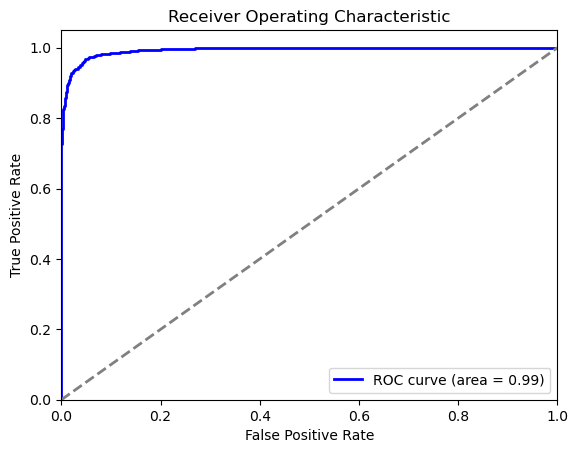

In [259]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score, roc_curve
# Calcular precisión
y_prob = random_search.predict_proba(x_test)[:, 1]
precision = precision_score(y_test, y_pred)
print(f'Precisión: {precision}')

# Calcular recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# Calcular F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Calcular AUC
auc = roc_auc_score(y_test, y_prob)
print(f'AUC: {auc}')

# Calcular los valores para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Dibujar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

#### Un accuracy alto en clases balanceadas puede ser un False Friend, mejor utilizar precision, F1 o Recall

In [234]:
from sklearn.linear_model import LogisticRegression

# Definir y entrenar el modelo
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

# Predecir y evaluar
y_pred_log_reg = log_reg.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")
precision = precision_score(y_test, y_pred_log_reg, average='macro')
print(f"Precision: {precision}")

Accuracy: 0.5039964476021315


In [247]:
from sklearn.ensemble import RandomForestClassifier

# Definir y entrenar el modelo
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

# Predecir y evaluar
y_pred_rf = rf.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
precision = precision_score(y_test, y_pred_rf, average='macro')
print(f"Precision: {precision}")

Accuracy: 0.9442717584369449
Precision: 0.9444769865894806


Ahora compruebo el rendimiento sin balancear

In [260]:
x=df.drop(columns='is_fraud')
y=df['is_fraud']

In [261]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3)

In [262]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


modelo=lgb.LGBMClassifier()

param_dist={'num_leaves':[30,50,70],
           'learning rate':[0.01,0.1,0.17],
           'n_estimators':[100,200,300]}


random_search= RandomizedSearchCV(modelo, param_distributions=param_dist, 
                                  n_iter=10, scoring='accuracy', cv=5, random_state=42)
random_search.fit(x_train, y_train)
y_pred = random_search.predict(x_test)
y_prob = random_search.predict_proba(x_test)[:, 1]

[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] 

In [268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 1017 to 1296427
Data columns (total 19 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   cc_num              1296675 non-null  int64  
 1   amt                 1296675 non-null  float64
 2   gender              1296675 non-null  int64  
 3   avg_trans_amt       1296675 non-null  float64
 4   trans_count         1296675 non-null  int64  
 5   days_since_last_tr  1296675 non-null  float64
 6   age                 1296675 non-null  int64  
 7   city_pop            1296675 non-null  int64  
 8   zip                 1296675 non-null  int64  
 9   lat                 1296675 non-null  float64
 10  long                1296675 non-null  float64
 11  merch_lat           1296675 non-null  float64
 12  merch_long          1296675 non-null  float64
 13  year                1296675 non-null  int64  
 14  month               1296675 non-null  int64  
 15  day         

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,roc_auc_score, roc_curve
# Calcular precisión
y_prob = random_search.predict_proba(x_test)[:, 1]
precision = precision_score(y_test, y_pred)
print(f'Precisión: {precision}')

# Calcular recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# Calcular F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Calcular AUC
auc = roc_auc_score(y_test, y_prob)
print(f'AUC: {auc}')

# Calcular los valores para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Dibujar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [263]:
from sklearn.linear_model import LogisticRegression

# Definir y entrenar el modelo
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

# Predecir y evaluar
y_pred_log_reg = log_reg.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")
precision = precision_score(y_test, y_pred_log_reg, average='macro')
print(f"Precision: {precision}")

Accuracy: 0.9942262656072061
Precision: 0.49711313280360303


C:\Users\110927\AppData\Local\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\110927\AppData\Local\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [264]:
from sklearn.ensemble import RandomForestClassifier

# Definir y entrenar el modelo
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

# Predecir y evaluar
y_pred_rf = rf.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
precision = precision_score(y_test, y_pred_rf, average='macro')
print(f"Precision: {precision}")

Accuracy: 0.9974550324804693
Precision: 0.9604600293348629
